**Imports**

In [72]:
# Imports

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from multiprocessing import cpu_count
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score

**Load Dataset**

In [73]:
# Loading dataset

df = pd.read_csv("/content/social_media_vs_productivity.csv")

df.head()



,age,gender,job_type,daily_social_media_time,social_platform_preference,number_of_notifications,work_hours_per_day,perceived_productivity_score,actual_productivity_score,stress_level,sleep_hours,screen_time_before_sleep,breaks_during_work,uses_focus_apps,has_digital_wellbeing_enabled,coffee_consumption_per_day,days_feeling_burnout_per_month,weekly_offline_hours,job_satisfaction_score
0,56,Male,Unemployed,4.180940,Facebook,61,6.753558,8.040464,7.291555,4.0,5.116546,0.419102,8,False,False,4,11,21.927072,6.336688
1,46,Male,Health,3.249603,Twitter,59,9.169296,5.063368,5.165093,7.0,5.103897,0.671519,7,True,True,2,25,0.000000,3.412427
2,32,Male,Finance,NaN,Twitter,57,7.910952,3.861762,3.474053,4.0,8.583222,0.624378,0,True,False,3,17,10.322044,2.474944
3,60,Female,Unemployed,NaN,Facebook,59,6.355027,2.916331,1.774869,6.0,6.052984,1.204540,1,False,False,0,4,23.876616,1.733670
4,25,Male,IT,NaN,Telegram,66,6.214096,8.868753,NaN,7.0,5.405706,1.876254,1,False,True,1,30,10.653519,9.693060


**Data Engineering** removing nan values and other outliers

In [74]:
# Preprocessing step: remove or replace NaN values

print(df.isna().sum().sort_values(ascending=False))
print("Orignal Dataset instances: ", len(df))
df.head()

# Drop rows with any NaN value

df_clean = df.dropna().reset_index(drop=True)

print(df_clean.isna().sum().sort_values(ascending=False))
print("After dropping NaNs:", len(df_clean))

daily_social_media_time           2765
job_satisfaction_score            2730
sleep_hours                       2598
actual_productivity_score         2365
screen_time_before_sleep          2211
stress_level                      1904
perceived_productivity_score      1614
job_type                             0
gender                               0
age                                  0
work_hours_per_day                   0
number_of_notifications              0
social_platform_preference           0
uses_focus_apps                      0
breaks_during_work                   0
has_digital_wellbeing_enabled        0
coffee_consumption_per_day           0
days_feeling_burnout_per_month       0
weekly_offline_hours                 0
dtype: int64
Orignal Dataset instances:  30000
age                               0
gender                            0
job_type                          0
daily_social_media_time           0
social_platform_preference        0
number_of_notifications         

In [75]:
# Applying one-hot-encoding to values that are objects and booleans.

df_encoded = pd.get_dummies(df_clean)
df_encoded.head()


print("Orignal df columns: \n", df_clean.columns)
print("Encoded df columns: \n",df_encoded.columns)

Orignal df columns: 
 Index(['age', 'gender', 'job_type', 'daily_social_media_time',
       'social_platform_preference', 'number_of_notifications',
       'work_hours_per_day', 'perceived_productivity_score',
       'actual_productivity_score', 'stress_level', 'sleep_hours',
       'screen_time_before_sleep', 'breaks_during_work', 'uses_focus_apps',
       'has_digital_wellbeing_enabled', 'coffee_consumption_per_day',
       'days_feeling_burnout_per_month', 'weekly_offline_hours',
       'job_satisfaction_score'],
      dtype='object')
Encoded df columns: 
 Index(['age', 'daily_social_media_time', 'number_of_notifications',
       'work_hours_per_day', 'perceived_productivity_score',
       'actual_productivity_score', 'stress_level', 'sleep_hours',
       'screen_time_before_sleep', 'breaks_during_work', 'uses_focus_apps',
       'has_digital_wellbeing_enabled', 'coffee_consumption_per_day',
       'days_feeling_burnout_per_month', 'weekly_offline_hours',
       'job_satisfaction_sc

In [76]:
# Inspecting dataset after one-hot-encoding:
df_encoded.info()
df_encoded.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17074 entries, 0 to 17073
Data columns (total 30 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   age                                   17074 non-null  int64  
 1   daily_social_media_time               17074 non-null  float64
 2   number_of_notifications               17074 non-null  int64  
 3   work_hours_per_day                    17074 non-null  float64
 4   perceived_productivity_score          17074 non-null  float64
 5   actual_productivity_score             17074 non-null  float64
 6   stress_level                          17074 non-null  float64
 7   sleep_hours                           17074 non-null  float64
 8   screen_time_before_sleep              17074 non-null  float64
 9   breaks_during_work                    17074 non-null  int64  
 10  uses_focus_apps                       17074 non-null  bool   
 11  has_digital_wel

,age,daily_social_media_time,number_of_notifications,work_hours_per_day,perceived_productivity_score,actual_productivity_score,stress_level,sleep_hours,screen_time_before_sleep,breaks_during_work,...,job_type_Finance,job_type_Health,job_type_IT,job_type_Student,job_type_Unemployed,social_platform_preference_Facebook,social_platform_preference_Instagram,social_platform_preference_Telegram,social_platform_preference_TikTok,social_platform_preference_Twitter
0,56,4.180940,61,6.753558,8.040464,7.291555,4.0,5.116546,0.419102,8,...,False,False,False,False,True,True,False,False,False,False
1,46,3.249603,59,9.169296,5.063368,5.165093,7.0,5.103897,0.671519,7,...,False,True,False,False,False,False,False,False,False,True
2,56,4.381070,60,3.902309,6.420989,5.976408,7.0,7.549849,2.252624,4,...,False,False,False,False,True,False,False,False,True,False
3,36,4.089168,49,6.560467,2.681830,2.446927,4.0,6.325507,0.747998,2,...,False,False,False,False,False,False,False,False,False,True
4,28,3.341559,57,11.022035,8.940636,7.983252,4.0,3.952547,1.028640,5,...,False,False,True,False,False,False,False,False,False,True


In [77]:
# renaming the cleaned dataset as the og
# Now we have:
# df_encoded: with one-hot-encoding columns for regressions models
# df_og: cleaned dataset for trees

df_og = df_clean


### Unique values for object and boolean datatypes. To be turned into numeric values for modeling. Mainly for tree functions, df_encoded for regression models

In [78]:



df_og.info()
df_og_columns = df.columns

for column in df_og_columns:
    if df_og[column].dtype == "object" or df_og[column].dtype == "bool":
        print(df_og[column].unique())

# Convert all unique values to numbers through mapping
for column in df_og_columns:
    if df_og[column].dtype == "object" or df_og[column].dtype == "bool":
        unique_values = df_og[column].unique()
        mapping = {value: i for i, value in enumerate(unique_values)}
        df_og[column] = df_og[column].map(mapping)

# Preview after mapping
df_og.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17074 entries, 0 to 17073
Data columns (total 19 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   age                             17074 non-null  int64  
 1   gender                          17074 non-null  object 
 2   job_type                        17074 non-null  object 
 3   daily_social_media_time         17074 non-null  float64
 4   social_platform_preference      17074 non-null  object 
 5   number_of_notifications         17074 non-null  int64  
 6   work_hours_per_day              17074 non-null  float64
 7   perceived_productivity_score    17074 non-null  float64
 8   actual_productivity_score       17074 non-null  float64
 9   stress_level                    17074 non-null  float64
 10  sleep_hours                     17074 non-null  float64
 11  screen_time_before_sleep        17074 non-null  float64
 12  breaks_during_work              

,age,gender,job_type,daily_social_media_time,social_platform_preference,number_of_notifications,work_hours_per_day,perceived_productivity_score,actual_productivity_score,stress_level,sleep_hours,screen_time_before_sleep,breaks_during_work,uses_focus_apps,has_digital_wellbeing_enabled,coffee_consumption_per_day,days_feeling_burnout_per_month,weekly_offline_hours,job_satisfaction_score
0,56,0,0,4.180940,0,61,6.753558,8.040464,7.291555,4.0,5.116546,0.419102,8,0,0,4,11,21.927072,6.336688
1,46,0,1,3.249603,1,59,9.169296,5.063368,5.165093,7.0,5.103897,0.671519,7,1,1,2,25,0.000000,3.412427
2,56,1,0,4.381070,2,60,3.902309,6.420989,5.976408,7.0,7.549849,2.252624,4,0,0,4,20,24.084905,5.501373
3,36,1,2,4.089168,1,49,6.560467,2.681830,2.446927,4.0,6.325507,0.747998,2,0,0,4,29,8.419648,3.444376
4,28,0,3,3.341559,1,57,11.022035,8.940636,7.983252,4.0,3.952547,1.028640,5,1,1,1,3,13.514515,9.414637


**Data Plots** to find out relationships between features and output

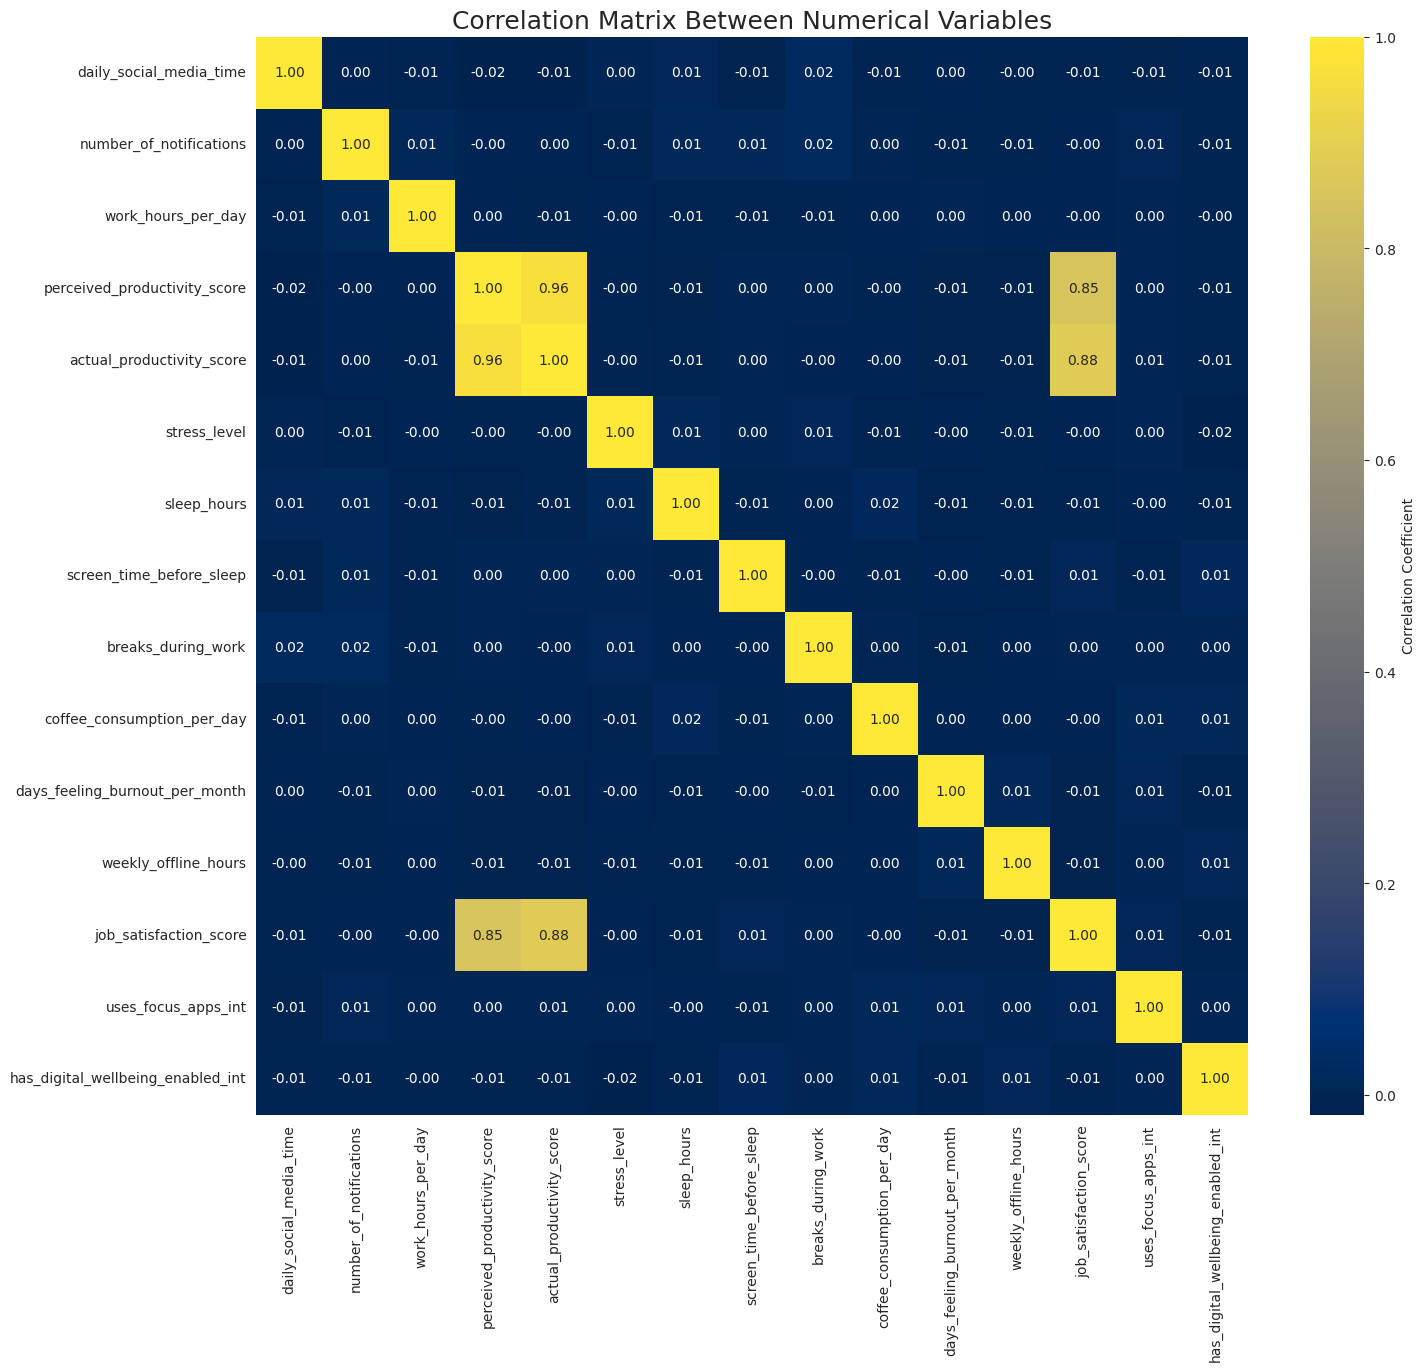

In [79]:
# Correlation between features

# Convert Boolean columns (True/False) to 1/0 before including them in the analysis
df_og['uses_focus_apps_int'] = df_og['uses_focus_apps'].astype(int)
df_og['has_digital_wellbeing_enabled_int'] = df_og['has_digital_wellbeing_enabled'].astype(int)

# All features with numerical values
numerical_cols = [
    'daily_social_media_time', 'number_of_notifications', 'work_hours_per_day',
    'perceived_productivity_score', 'actual_productivity_score', 'stress_level',
    'sleep_hours', 'screen_time_before_sleep', 'breaks_during_work',
    'coffee_consumption_per_day', 'days_feeling_burnout_per_month',
    'weekly_offline_hours', 'job_satisfaction_score',
    'uses_focus_apps_int', 'has_digital_wellbeing_enabled_int'
]

# Corrolation Matrix
corr_matrix = df_og[numerical_cols].corr()

plt.figure(figsize=(16, 14))
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap='cividis',
    cbar_kws={'label': 'Correlation Coefficient'}
)
plt.title('Correlation Matrix Between Numerical Variables', fontsize=18)
plt.show()

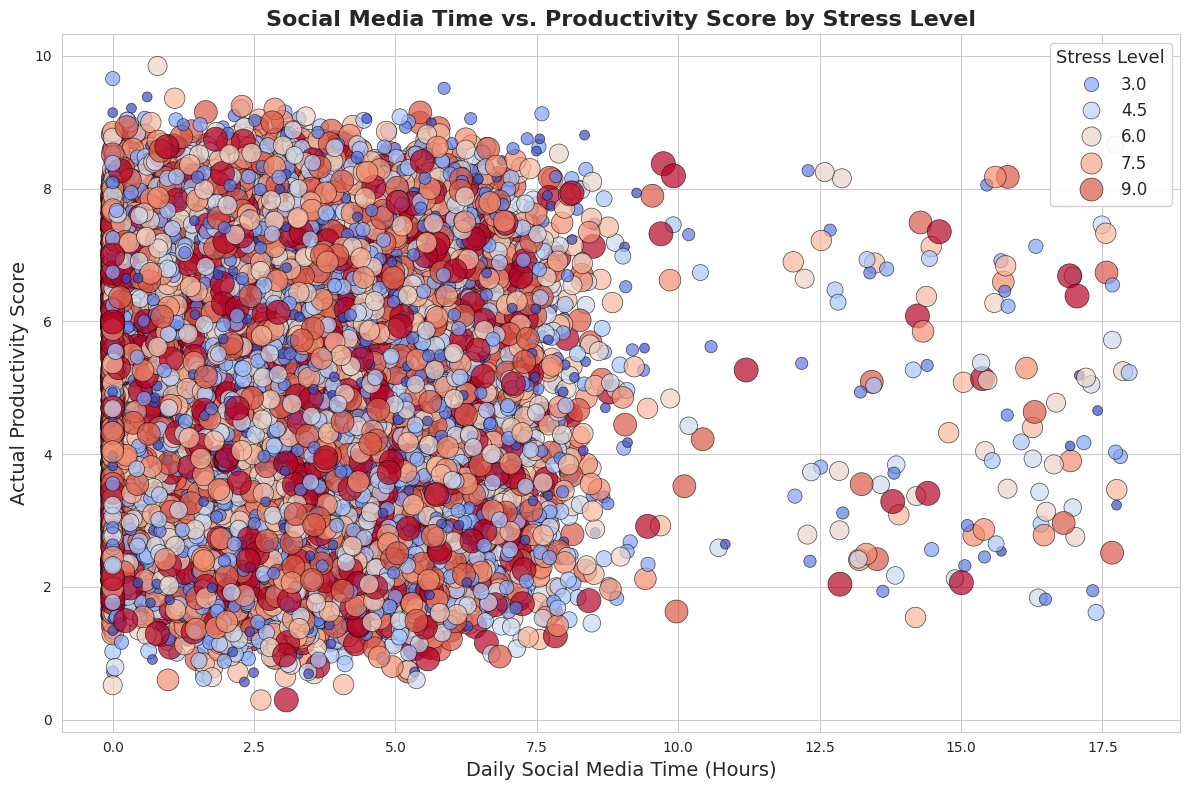

In [80]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 8))
sns.set_style("whitegrid")

scatter = sns.scatterplot(
    data=df,
    x='daily_social_media_time',
    y='actual_productivity_score',
    hue='stress_level',
    palette='coolwarm',
    size='stress_level',
    sizes=(50, 300),
    alpha=0.7,
    edgecolor='black',
    linewidth=0.5
)

plt.title('Social Media Time vs. Productivity Score by Stress Level', fontsize=16, weight='bold')
plt.xlabel('Daily Social Media Time (Hours)', fontsize=14)
plt.ylabel('Actual Productivity Score', fontsize=14)

# Improve legend
handles, labels = scatter.get_legend_handles_labels()
plt.legend(handles=handles[1:], labels=labels[1:], title='Stress Level', loc='upper right', frameon=True, framealpha=0.9, fontsize=12, title_fontsize=13)

plt.tight_layout()
plt.show()


**Regression**

In [81]:


# features that don't have anything to do with productivity, as well as the output.
output_columns = ['perceived_productivity_score', 'actual_productivity_score']

# Features and labels for clean og dataset without one-hot-encoding
X_og = df_og.drop(columns=output_columns)
Y_og = df_og['actual_productivity_score']

# Features and labels for clean og dataset with one-hot-encoding
X_encoded = df_encoded.drop(columns=output_columns)
Y_encoded = df_encoded['actual_productivity_score']


convery dataframes to numpy arrays

In [82]:
# Convert to numpy arrays

X_og = X_og.to_numpy()
X_encoded = X_encoded.to_numpy()

Y_og = Y_og.to_numpy()
Y_encoded = Y_encoded.to_numpy()

**Splitting datasets into train/test/val**

In [83]:
from sklearn.model_selection import train_test_split

# Desired fractions
test_size = 0.1
val_size = 0.1

# Original dataset splits

X_og_trainval, X_og_test, y_og_trainval, y_og_test = train_test_split(
    X_og, Y_og, test_size=test_size, random_state=42
)

val_fraction = val_size / (1 - test_size)

X_og_train, X_og_val, y_og_train, y_og_val = train_test_split(
    X_og_trainval, y_og_trainval, test_size=val_fraction, random_state=42
)


# One-hot encoded dataset splits

X_enc_trainval, X_enc_test, y_enc_trainval, y_enc_test = train_test_split(
    X_encoded, Y_encoded, test_size=test_size, random_state=42
)

val_fraction = val_size / (1 - test_size)

X_enc_train, X_enc_val, y_enc_train, y_enc_val = train_test_split(
    X_enc_trainval, y_enc_trainval, test_size=val_fraction, random_state=42
)


**Shapes of data** One-hot encoded (for linear models)  and orignal data (for trees)

In [84]:
# %% Check shapes for original dataset
print("Original dataset shapes:")
print(f"X_og_train shape: {X_og_train.shape}")
print(f"X_og_val shape:   {X_og_val.shape}")
print(f"X_og_test shape:  {X_og_test.shape}")
print(f"y_og_train shape: {y_og_train.shape}")
print(f"y_og_val shape:   {y_og_val.shape}")
print(f"y_og_test shape:  {y_og_test.shape}\n")

# %% Check shapes for one-hot encoded dataset
print("One-hot encoded dataset shapes:")
print(f"X_enc_train shape: {X_enc_train.shape}")
print(f"X_enc_val shape:   {X_enc_val.shape}")
print(f"X_enc_test shape:  {X_enc_test.shape}")
print(f"y_enc_train shape: {y_enc_train.shape}")
print(f"y_enc_val shape:   {y_enc_val.shape}")
print(f"y_enc_test shape:  {y_enc_test.shape}")


Original dataset shapes:
X_og_train shape: (13658, 19)
X_og_val shape:   (1708, 19)
X_og_test shape:  (1708, 19)
y_og_train shape: (13658,)
y_og_val shape:   (1708,)
y_og_test shape:  (1708,)

One-hot encoded dataset shapes:
X_enc_train shape: (13658, 28)
X_enc_val shape:   (1708, 28)
X_enc_test shape:  (1708, 28)
y_enc_train shape: (13658,)
y_enc_val shape:   (1708,)
y_enc_test shape:  (1708,)


## **Light GBM Model Training**

***Histogram Based Splitting***



1.  Continuous features are binned into discrete bins.
2.  LightGBM builds a histogram per feature.
3.  It finds the best split by scanning these bins rather than raw values.
4.  Chooses leaf with the largest reduction in loss

***Base Model***

In [85]:
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score
import numpy as np

# Train model
model = LGBMRegressor(
    n_estimators=500,
    learning_rate=0.05,
    num_leaves=31,
    random_state=42
)
model.fit(X_og_train, y_og_train)

# Predict
preds = model.predict(X_og_test)

# Compute metrics
mse = mean_squared_error(y_og_test, preds)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_og_test, preds)
r2 = r2_score(y_og_test, preds)
explained_var = explained_variance_score(y_og_test, preds)

# Print nicely
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R^2 Score: {r2:.4f}")
print(f"Explained Variance: {explained_var:.4f}")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001983 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1721
[LightGBM] [Info] Number of data points in the train set: 13658, number of used features: 19
[LightGBM] [Info] Start training from score 4.939835
Mean Squared Error (MSE): 0.7535
Root Mean Squared Error (RMSE): 0.8680
Mean Absolute Error (MAE): 0.6900
R^2 Score: 0.7961
Explained Variance: 0.7963


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


***Feature Importance***

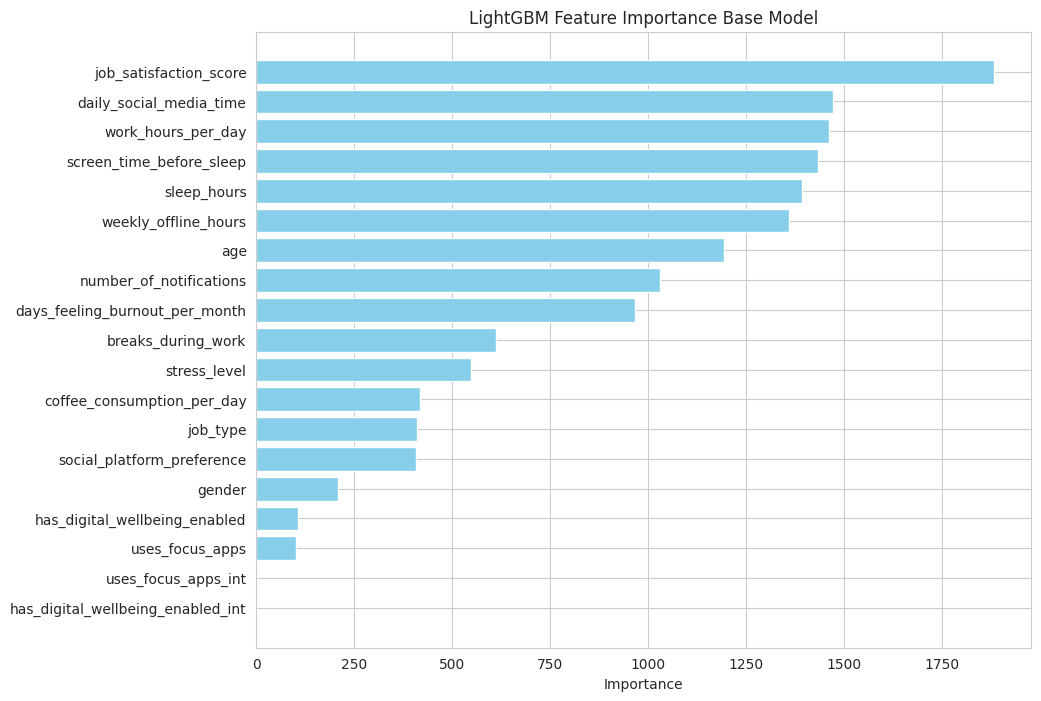

In [86]:
import matplotlib.pyplot as plt
import numpy as np


output_columns = ['perceived_productivity_score', 'actual_productivity_score']

feature_names = df_og.drop(columns=output_columns).columns.tolist()

importances = model.feature_importances_

indices = np.argsort(importances)

plt.figure(figsize=(10, 8))
plt.barh(range(len(importances)), importances[indices], color='skyblue')
plt.yticks(range(len(importances)), [feature_names[i] for i in indices])
plt.xlabel("Importance")
plt.title("LightGBM Feature Importance Base Model")
plt.show()



***Results from base model***

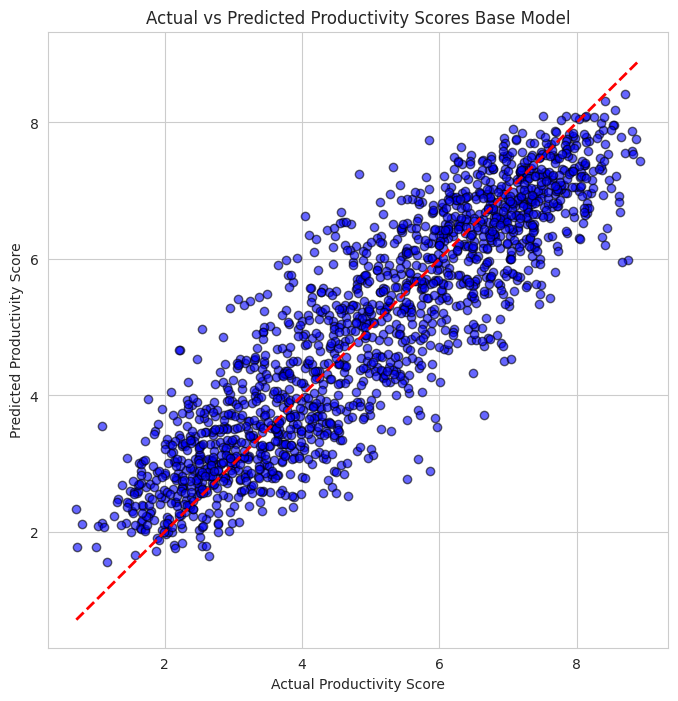

In [87]:
import matplotlib.pyplot as plt

# Actual vs Predicted
plt.figure(figsize=(8, 8))
plt.scatter(y_og_test, preds, alpha=0.6, color='blue', edgecolors='k')
plt.plot([y_og_test.min(), y_og_test.max()],
         [y_og_test.min(), y_og_test.max()],
         'r--', lw=2)  # diagonal line
plt.xlabel("Actual Productivity Score")
plt.ylabel("Predicted Productivity Score")
plt.title("Actual vs Predicted Productivity Scores Base Model")
plt.grid(True)
plt.show()


***Validation with early stopping***

In [88]:
from lightgbm import LGBMRegressor, early_stopping, log_evaluation, record_evaluation
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score
import numpy as np

eval_results = {}


model = LGBMRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    num_leaves=31,
    random_state=42
)


model.fit(
    X_og_train, y_og_train,
    eval_set=[(X_og_val, y_og_val)],
    eval_metric='l2',  # MSE
    callbacks=[
        early_stopping(stopping_rounds=50),
        log_evaluation(period=50),
        record_evaluation(eval_results)
    ]
)


val_preds = model.predict(X_og_val)

val_mse = mean_squared_error(y_og_val, val_preds)
val_rmse = np.sqrt(val_mse)
val_mae = mean_absolute_error(y_og_val, val_preds)
val_r2 = r2_score(y_og_val, val_preds)
val_expl_var = explained_variance_score(y_og_val, val_preds)


val_metrics = {
    "MSE": val_mse,
    "RMSE": val_rmse,
    "MAE": val_mae,
    "R²": val_r2,
    "Explained Variance": val_expl_var
}

print("\n=== Validation Set Metrics ===")
print(f"{'Metric':<20} | {'Value':>10}")
print("-" * 33)
for name, value in val_metrics.items():
    print(f"{name:<20} | {value:>10.4f}")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014703 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1721
[LightGBM] [Info] Number of data points in the train set: 13658, number of used features: 19
[LightGBM] [Info] Start training from score 4.939835
Training until validation scores don't improve for 50 rounds
[50]	valid_0's l2: 0.774204
[100]	valid_0's l2: 0.75669
Early stopping, best iteration is:
[83]	valid_0's l2: 0.756237

=== Validation Set Metrics ===
Metric               |      Value
---------------------------------
MSE                  |     0.7562
RMSE                 |     0.8696
MAE                  |     0.7010
R²                   |     0.7870
Explained Variance   |     0.7872


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


**validation with early stopping graph (MSE)**

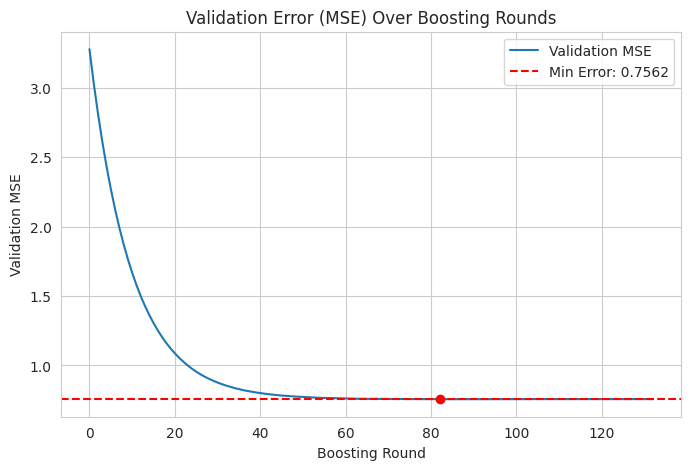

In [89]:
import matplotlib.pyplot as plt
import numpy as np

val_errors = eval_results['valid_0']['l2']   #


min_error = np.min(val_errors)
best_round = np.argmin(val_errors)

plt.figure(figsize=(8,5))
plt.plot(val_errors, label='Validation MSE')
plt.axhline(y=min_error, color='red', linestyle='--', label=f'Min Error: {min_error:.4f}')
plt.scatter(best_round, min_error, color='red', zorder=5)
plt.xlabel("Boosting Round")
plt.ylabel("Validation MSE")
plt.title("Validation Error (MSE) Over Boosting Rounds")
plt.grid(True)
plt.legend()
plt.show()


***Validation without Early Stopping***

In [90]:
from lightgbm import LGBMRegressor, log_evaluation, record_evaluation
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score
import numpy as np


eval_results = {}


model = LGBMRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    num_leaves=31,
    random_state=42
)


model.fit(
    X_og_train, y_og_train,
    eval_set=[(X_og_val, y_og_val)],
    eval_metric='l2',
    callbacks=[
        log_evaluation(period=50),
        record_evaluation(eval_results)
    ]
)


val_preds = model.predict(X_og_val)


val_mse = mean_squared_error(y_og_val, val_preds)
val_rmse = np.sqrt(val_mse)
val_mae = mean_absolute_error(y_og_val, val_preds)
val_r2 = r2_score(y_og_val, val_preds)
val_expl_var = explained_variance_score(y_og_val, val_preds)


val_metrics = {
    "MSE": val_mse,
    "RMSE": val_rmse,
    "MAE": val_mae,
    "R²": val_r2,
    "Explained Variance": val_expl_var
}


print("\n  Validation Set Metrics ")
print(f"{'Metric':<20} | {'Value':>10}")
print("-" * 33)
for name, value in val_metrics.items():
    print(f"{name:<20} | {value:>10.4f}")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001273 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1721
[LightGBM] [Info] Number of data points in the train set: 13658, number of used features: 19
[LightGBM] [Info] Start training from score 4.939835
[50]	valid_0's l2: 0.774204
[100]	valid_0's l2: 0.75669
[150]	valid_0's l2: 0.7571
[200]	valid_0's l2: 0.759025
[250]	valid_0's l2: 0.760722
[300]	valid_0's l2: 0.764376
[350]	valid_0's l2: 0.76735
[400]	valid_0's l2: 0.770885
[450]	valid_0's l2: 0.774255
[500]	valid_0's l2: 0.777065
[550]	valid_0's l2: 0.778953
[600]	valid_0's l2: 0.781391
[650]	valid_0's l2: 0.781663
[700]	valid_0's l2: 0.783943
[750]	valid_0's l2: 0.785033
[800]	valid_0's l2: 0.785637
[850]	valid_0's l2: 0.785774
[900]	valid_0's l2: 0.787372
[950]	valid_0's l2: 0.788884
[1000]	valid_0's l2: 0.790175

  Validation Set 

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


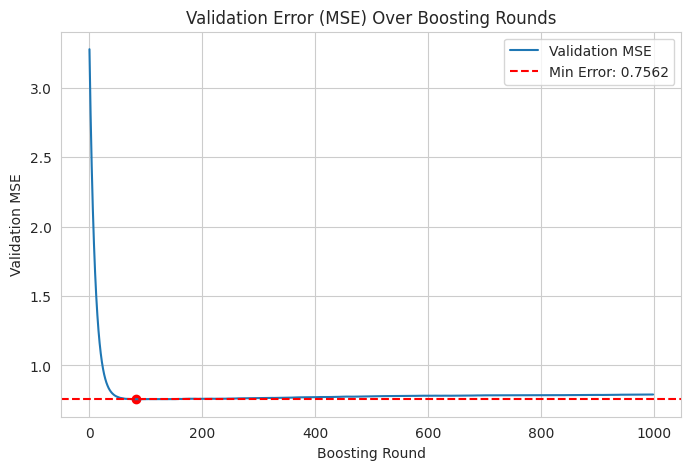

In [91]:
import matplotlib.pyplot as plt
import numpy as np

val_errors = eval_results['valid_0']['l2']


min_error = np.min(val_errors)
best_round = np.argmin(val_errors)

plt.figure(figsize=(8,5))
plt.plot(val_errors, label='Validation MSE')
plt.axhline(y=min_error, color='red', linestyle='--', label=f'Min Error: {min_error:.4f}')
plt.scatter(best_round, min_error, color='red')
plt.xlabel("Boosting Round")
plt.ylabel("Validation MSE")
plt.title("Validation Error (MSE) Over Boosting Rounds")
plt.grid(True)
plt.legend()
plt.show()


***Cross Validation Using K-Fold***

In [92]:
from lightgbm import LGBMRegressor
from sklearn.model_selection import KFold, cross_val_score
import numpy as np


cv_model = LGBMRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    num_leaves=31,
    random_state=42
)


kf = KFold(n_splits=5, shuffle=True, random_state=42)


cv_scores = cross_val_score(
    cv_model,
    X_og_train,
    y_og_train,
    cv=kf,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

cv_mse = -cv_scores
cv_rmse = np.sqrt(cv_mse)


print("5-Fold Cross-Validation Metrics:")
print(f"MSE:  {cv_mse.mean():.4f} ± {cv_mse.std():.4f}")
print(f"RMSE: {cv_rmse.mean():.4f} ± {cv_rmse.std():.4f}")


5-Fold Cross-Validation Metrics:
MSE:  0.8158 ± 0.0127
RMSE: 0.9032 ± 0.0070


**Hyperparameter Tuning with Grid Search CV**

In [93]:
import time
from lightgbm import LGBMRegressor
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import make_scorer, mean_squared_error


fit_times = []

def log_fit_time(estimator, X, y):
    start = time.time()
    estimator.fit(X, y)
    end = time.time()

    elapsed = end - start
    fit_times.append({
        "params": estimator.get_params(),
        "time_sec": elapsed
    })

    print(f"fit completed in {elapsed:.3f} sec with params:")
    print(estimator.get_params())
    return estimator

model = LGBMRegressor(random_state=42)

param_grid = {
    'num_leaves': [7, 14, 21, 28, 31, 50],
    'learning_rate': [0.1, 0.03, 0.003],
    'max_depth': [-1, 3, 5],
    'n_estimators': [50, 100, 200, 500]
}


kf = KFold(n_splits=5, shuffle=True, random_state=42)

mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)


class TimedGridSearchCV(GridSearchCV):
    def _fit_and_score(self, *args, **kwargs):
        start = time.time()
        result = super()._fit_and_score(*args, **kwargs)
        elapsed = time.time() - start

        params = args[2]
        fit_times.append({
            "params": params,
            "time_sec": elapsed
        })
        print(f"iteration time: {elapsed:.3f} sec | Params: {params}")

        return result

grid_search = TimedGridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring=mse_scorer,
    cv=kf,
    n_jobs=-1,
    verbose=2
)

total_start = time.time()
grid_search.fit(X_og_train, y_og_train)
total_end = time.time()


print(f"GRID SEARCH TIME: {total_end - total_start:.2f} sec")


print("Best Parameters:", grid_search.best_params_)
print("Best CV MSE:", -grid_search.best_score_)


print("\n Timing Log (first 10 entries)")
for entry in fit_times[:10]:
    print(entry)


Fitting 5 folds for each of 216 candidates, totalling 1080 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001219 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1721
[LightGBM] [Info] Number of data points in the train set: 13658, number of used features: 19
[LightGBM] [Info] Start training from score 4.939835
GRID SEARCH TIME: 331.59 sec
Best Parameters: {'learning_rate': 0.03, 'max_depth': -1, 'n_estimators': 200, 'num_leaves': 7}
Best CV MSE: 0.7561132917290531

 Timing Log (first 10 entries)


***Using Best Model***

In [94]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np


best_model = grid_search.best_estimator_
y_test_preds = best_model.predict(X_og_test)

test_mse = mean_squared_error(y_og_test, y_test_preds)
test_rmse = np.sqrt(test_mse)
test_mae = mean_absolute_error(y_og_test, y_test_preds)
test_r2 = r2_score(y_og_test, y_test_preds)


metrics = {
    "MSE": test_mse,
    "RMSE": test_rmse,
    "MAE": test_mae,
    "R²": test_r2
}

print("\n Test Set Metrics ")
print(f"{'Metric':<10} | {'Value':>10}")
print("-" * 23)
for name, value in metrics.items():
    print(f"{name:<10} | {value:>10.4f}")



 Test Set Metrics 
Metric     |      Value
-----------------------
MSE        |     0.7303
RMSE       |     0.8546
MAE        |     0.6801
R²         |     0.8024


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


***Feature Importance for best model***

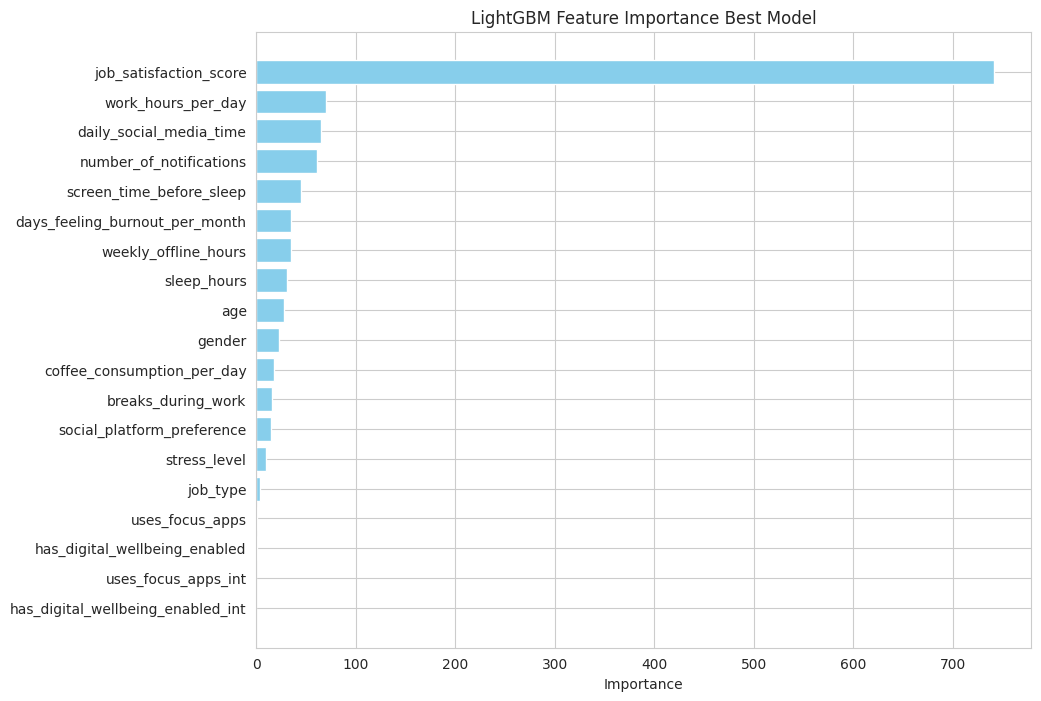

In [95]:
import matplotlib.pyplot as plt
import numpy as np


output_columns = ['perceived_productivity_score', 'actual_productivity_score']

feature_names = df_og.drop(columns=output_columns).columns.tolist()

importances = best_model.feature_importances_

indices = np.argsort(importances)

plt.figure(figsize=(10, 8))
plt.barh(range(len(importances)), importances[indices], color='skyblue')
plt.yticks(range(len(importances)), [feature_names[i] for i in indices])
plt.xlabel("Importance")
plt.title("LightGBM Feature Importance Best Model")
plt.show()



**Applying PCA**

Original number of features: 19
Reduced number of features after PCA: 16
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003154 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 13658, number of used features: 16
[LightGBM] [Info] Start training from score 4.939835
[50]	valid_0's l2: 2.15792
[100]	valid_0's l2: 1.71935
[150]	valid_0's l2: 1.52349
[200]	valid_0's l2: 1.41812

=== Test Metrics on PCA-Transformed Data ===
Metric     |      Value
-----------------------
MSE        |     1.5290
RMSE       |     1.2365
MAE        |     0.9979
R²         |     0.5863


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


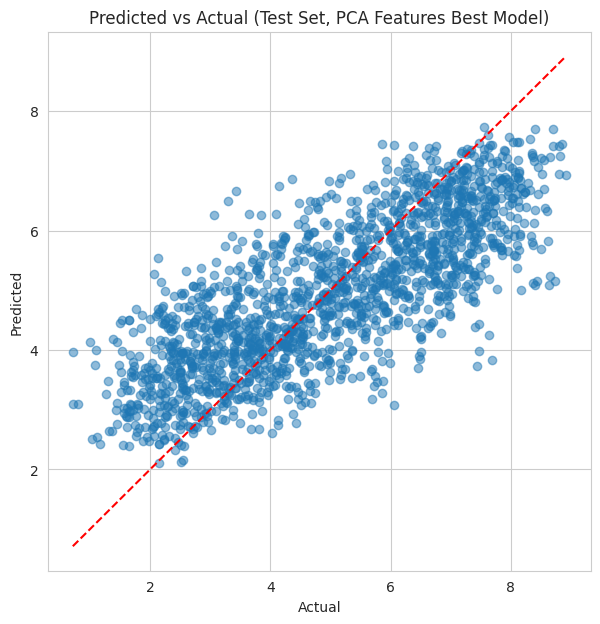

In [96]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from lightgbm import LGBMRegressor, log_evaluation
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import matplotlib.pyplot as plt


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_og_train)
X_val_scaled = scaler.transform(X_og_val)
X_test_scaled = scaler.transform(X_og_test)


pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train_scaled)
X_val_pca = pca.transform(X_val_scaled)
X_test_pca = pca.transform(X_test_scaled)

print("Original number of features:", X_og_train.shape[1])
print("Reduced number of features after PCA:", X_train_pca.shape[1])


best_model_pca = LGBMRegressor(**best_model.get_params())
best_model_pca.fit(
    X_train_pca, y_og_train,
    eval_set=[(X_val_pca, y_og_val)],
    eval_metric='l2',
    callbacks=[log_evaluation(period=50)]
)


y_test_preds_pca = best_model_pca.predict(X_test_pca)


# Evaluate metrics
test_mse = mean_squared_error(y_og_test, y_test_preds_pca)
test_rmse = np.sqrt(test_mse)
test_mae = mean_absolute_error(y_og_test, y_test_preds_pca)
test_r2 = r2_score(y_og_test, y_test_preds_pca)


metrics = {
    "MSE": test_mse,
    "RMSE": test_rmse,
    "MAE": test_mae,
    "R²": test_r2
}

print("\n=== Test Metrics on PCA-Transformed Data ===")
print(f"{'Metric':<10} | {'Value':>10}")
print("-" * 23)
for name, value in metrics.items():
    print(f"{name:<10} | {value:>10.4f}")

plt.figure(figsize=(7,7))
plt.scatter(y_og_test, y_test_preds_pca, alpha=0.5)
plt.plot([y_og_test.min(), y_og_test.max()],
         [y_og_test.min(), y_og_test.max()],
         linestyle='--', color='red')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Predicted vs Actual (Test Set, PCA Features Best Model)")
plt.show()


***Using Other Models***

In [97]:
from sklearn.linear_model import SGDRegressor, Lasso, Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_enc_train)
X_val_scaled = scaler.transform(X_enc_val)
X_test_scaled = scaler.transform(X_enc_test)

models = {
    "SGDRegressor": SGDRegressor(max_iter=1000, tol=1e-3, random_state=42),
    "Ridge": Ridge(alpha=1.0, random_state=42),
    "Lasso": Lasso(alpha=0.01, random_state=42)
}


results = {}

for name, model in models.items():
    model.fit(X_train_scaled, y_enc_train)
    y_test_preds = model.predict(X_test_scaled)

    results[name] = {
        "MSE": mean_squared_error(y_enc_test, y_test_preds),
        "RMSE": np.sqrt(mean_squared_error(y_enc_test, y_test_preds)),
        "MAE": mean_absolute_error(y_enc_test, y_test_preds),
        "R²": r2_score(y_enc_test, y_test_preds)
    }


print("\n=== Linear Models Comparison (Test Set) ===")
print(f"{'Model':<15} | {'MSE':>10} | {'RMSE':>10} | {'MAE':>10} | {'R²':>10}")
print("-" * 65)
for model_name, metrics in results.items():
    print(f"{model_name:<15} | {metrics['MSE']:>10.4f} | {metrics['RMSE']:>10.4f} | "
          f"{metrics['MAE']:>10.4f} | {metrics['R²']:>10.4f}")



=== Linear Models Comparison (Test Set) ===
Model           |        MSE |       RMSE |        MAE |         R²
-----------------------------------------------------------------
SGDRegressor    |     0.7720 |     0.8786 |     0.7034 |     0.7911
Ridge           |     0.7666 |     0.8755 |     0.7000 |     0.7926
Lasso           |     0.7670 |     0.8758 |     0.6997 |     0.7925
